In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import librosa
import IPython.display as ipd
from datasets import load_dataset
from transformers import AutoConfig, Wav2Vec2Processor, EvalPrediction, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List, Union
import torch
from transformers.file_utils import ModelOutput
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)
import transformers
from typing import Any, Dict, Union
from packaging import version
from transformers import (
    Trainer,
    is_apex_available,
) 
if is_apex_available():
    from apex import amp

# Data Recovery

In [2]:
emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

data = []

dataset_path = Path("../dataset")

for path in tqdm(dataset_path.glob("**/*.wav")):
    name = str(path).split('\\')[-1].split('.')[0]
    label_code = name.split('-')[2]  # Emotional Code Extraction
    emotion = emotion_mapping.get(label_code, "unknown")

    try:
        s = torchaudio.load(path)
        # File added to "data" in dictionary format
        data.append({
            "name": name,
            "path": str(path),
            "emotion": emotion
        })
    except Exception as e:
        pass


1440it [00:02, 514.83it/s]


In [3]:
df = pd.DataFrame(data)
df.head()

,name,path,emotion
0,03-01-01-01-01-01-01,..\dataset\Actor_01\03-01-01-01-01-01-01.wav,neutral
1,03-01-01-01-01-02-01,..\dataset\Actor_01\03-01-01-01-01-02-01.wav,neutral
2,03-01-01-01-02-01-01,..\dataset\Actor_01\03-01-01-01-02-01-01.wav,neutral
3,03-01-01-01-02-02-01,..\dataset\Actor_01\03-01-01-01-02-02-01.wav,neutral
4,03-01-02-01-01-01-01,..\dataset\Actor_01\03-01-02-01-01-01-01.wav,calm


## Data cleaning and mixing

In [4]:
print(f"Number of audio files before cleaning: {len(df)}")

df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["path"])
df = df.drop("status", axis=1)

print(f"Number of audio files after cleaning: {len(df)}")

# Data mixing
df = df.sample(frac=1)
df = df.reset_index(drop=True)

df.head()

Number of audio files before cleaning: 1440
Number of audio files after cleaning: 1440


,name,path,emotion
0,03-01-06-02-01-01-17,..\dataset\Actor_17\03-01-06-02-01-01-17.wav,fearful
1,03-01-06-01-02-02-01,..\dataset\Actor_01\03-01-06-01-02-02-01.wav,fearful
2,03-01-06-01-01-01-18,..\dataset\Actor_18\03-01-06-01-01-01-18.wav,fearful
3,03-01-08-01-02-02-17,..\dataset\Actor_17\03-01-08-01-02-02-17.wav,surprised
4,03-01-07-01-02-01-02,..\dataset\Actor_02\03-01-07-01-02-01-02.wav,disgust


## Visualizing data distribution

C:\Users\aubin\AppData\Local\Temp\ipykernel_30928\806197252.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")


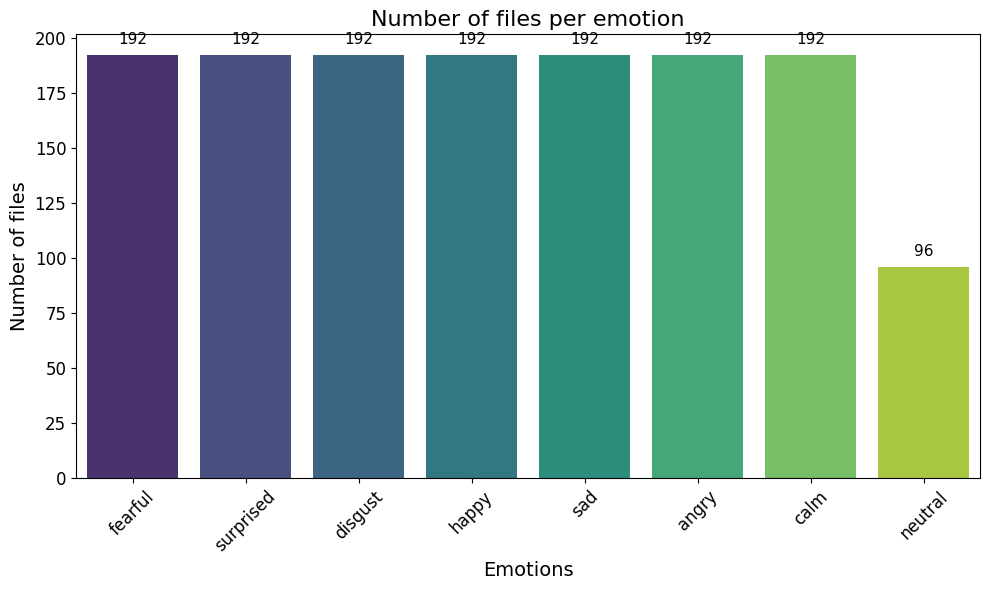

In [5]:
emotion_counts = df["emotion"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")

plt.title("Number of files per emotion", fontsize=16)
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Number of files", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(emotion_counts.values):
    plt.text(index, value + 5, str(value), ha='center', fontsize=11)

plt.tight_layout()
plt.show()


## Split and save training and test sets

In [6]:
save_path = "../dataset_csv"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save
train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)

(1152, 3)
(288, 3)


## Load data

In [7]:
data_files = {
    "train": "../dataset_csv/train.csv", 
    "validation": "../dataset_csv/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Generating train split: 1152 examples [00:00, 32250.96 examples/s]
Generating validation split: 288 examples [00:00, 26032.49 examples/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1152
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 288
})


In [8]:
input_column = "path"
output_column = "emotion"

### Control step to detect anomalies in the training assembly

In [9]:
label_list = train_dataset.unique(output_column)
label_list.sort()
num_labels = len(label_list)

print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 8 classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# Selection of pre-trained model

In [10]:
model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
pooling_mode = "mean"

## Prepare the model for fine-tuning

In [11]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

c:\Users\aubin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [12]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
# Sampling rate expected by the model
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


# Preprocess Data

In [13]:
# Load an audio file and transform it into an array of numerical values.
def speech_file_to_array_fn(path):
    # speech_array -> tensor with audio data
    # sampling_rate -> audio file sample rate
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    if speech.ndim == 0:
        speech = np.array([speech])
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    speech_list = [np.asarray(speech).flatten() for speech in speech_list]
    
    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [14]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1,
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1,
)

Map: 100%|██████████| 288/288 [00:03<00:00, 89.69 examples/s]


In [15]:
idx = 2
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.0007517646881751716, 0.00075176

# Model

## Structuring the model output

In [16]:
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [17]:
# Classification header which takes features extracted by Wav2Vec2 and transforms them into logits for classification
class Wav2Vec2ClassificationHead(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


In [18]:
# Definition of a classification model based on Wav2Vec2 for speech
class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    # Method for freezing the feature extractor parameters of the Wav2Vec2 model (for fine-tuning)
    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    # Method which aggregates hidden states -> allows transforming the outputs of the Wav2Vec2 model into a compact vector for classification
    def merged_strategy(self, hidden_states, mode="mean"):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")
        return outputs
    
    def forward(self, input_values, attention_mask=None, output_attentions=None, output_hidden_states=None, return_dict=None, labels=None, ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



# Training

In [19]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [20]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [21]:
is_regression = False

In [22]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [23]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at lighteternal/wav2vec2-large-xlsr-53-greek and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.freeze_feature_extractor()

In [25]:
training_args = TrainingArguments(
    output_dir="/content/wav2vec2-xlsr-greek-speech-emotion-recognition",
    # output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=1.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

c:\Users\aubin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1570: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


# class CTCTrainer(Trainer):
#     def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]], num_items_in_batch: int) -> torch.Tensor:
#         model.train()
#         inputs = self._prepare_inputs(inputs)

#         if self.use_amp:
#             with autocast():
#                 loss = self.compute_loss(model, inputs)
#         else:
#             loss = self.compute_loss(model, inputs)

#         if self.args.gradient_accumulation_steps > 1:
#             loss = loss / self.args.gradient_accumulation_steps

#         if self.use_amp:
#             self.scaler.scale(loss).backward()
#         elif self.use_apex:
#             with amp.scale_loss(loss, self.optimizer) as scaled_loss:
#                 scaled_loss.backward()
#         elif self.deepspeed:
#             self.deepspeed.backward(loss)
#         else:
#             loss.backward()

#         return loss.detach()
    
#     def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
#         """
#         Perform a training step on a batch of inputs.

#         Subclass and override to inject custom behavior.

#         Args:
#             model (:obj:`nn.Module`):
#                 The model to train.
#             inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
#                 The inputs and targets of the model.

#                 The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
#                 argument :obj:`labels`. Check your model's documentation for all accepted arguments.

#         Return:
#             :obj:`torch.Tensor`: The tensor with training loss on this batch.
#         """

#         model.train()
#         inputs = self._prepare_inputs(inputs)

#         if self.use_amp:
#             with autocast():
#                 loss = self.compute_loss(model, inputs)
#         else:
#             loss = self.compute_loss(model, inputs)

#         if self.args.gradient_accumulation_steps > 1:
#             loss = loss / self.args.gradient_accumulation_steps

#         if self.use_amp:
#             self.scaler.scale(loss).backward()
#         elif self.use_apex:
#             with amp.scale_loss(loss, self.optimizer) as scaled_loss:
#                 scaled_loss.backward()
#         elif self.deepspeed:
#             self.deepspeed.backward(loss)
#         else:
#             loss.backward()

#         return loss.detach()

class CTCTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        # Remove use_amp from kwargs before passing to parent constructor
        self.use_amp = kwargs.pop('use_amp', False)
        self.use_apex = kwargs.pop('use_apex', False)
        self.deepspeed = kwargs.pop('deepspeed', False)
        
        # Initialize the parent constructor with remaining kwargs
        super().__init__(*args, **kwargs)
        
        # Initialize scaler if using AMP
        if self.use_amp:
            self.scaler = torch.cuda.amp.GradScaler()

    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]], num_items_in_batch: int) -> torch.Tensor:
        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()

# When creating the trainer, you can now specify these options
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
    use_amp=True  # This will now be properly handled
)


C:\Users\aubin\AppData\Local\Temp\ipykernel_30928\1218580024.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CTCTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
C:\Users\aubin\AppData\Local\Temp\ipykernel_30928\1218580024.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [37]:
# trainer = CTCTrainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     tokenizer=processor.feature_extractor,
# )

In [40]:
trainer.train()

C:\Users\aubin\AppData\Local\Temp\ipykernel_30928\1218580024.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


KeyboardInterrupt: 